In [8]:
%load_ext autoreload
%autoreload 2
%env PYDEVD_DISABLE_FILE_VALIDATION=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYDEVD_DISABLE_FILE_VALIDATION=1


In [9]:
import sys
sys.path.append('Cpp_lib')
import adjugate_module

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math 

from noise_generator import  stack_noise #, interp_stack_noise, interp_dict_noise
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math 
import os
from tqdm.auto import tqdm
# from robot_dynamics import compute_Y, robot_dynamics, error_dynamics, filter_dynamics
# from matrix_operation import compute_adjugate_old, compute_adjugate_scipy, drem_adapt, regularizing_operator, regressor

# the below solved by solve_ivp
from DREM_routine import robot_dynamics_w_control_adaptation
#  analysis and save utils
from utils import analysis_result, save_params, save_as_pickle
from noise_generator import wrap_interp_func, parse_noise_interp_dict
from pseudo_signal import MaxLengthSequence3D
# import sys
# sys.path.append('~/Dropbox/PJ ModelDetection/DREM/DREM_implementation/Cpp_lib')
# import adjugate_module

Values at time 500.1: (0.10000000000002274, 1.0, 0.8999999999999773)


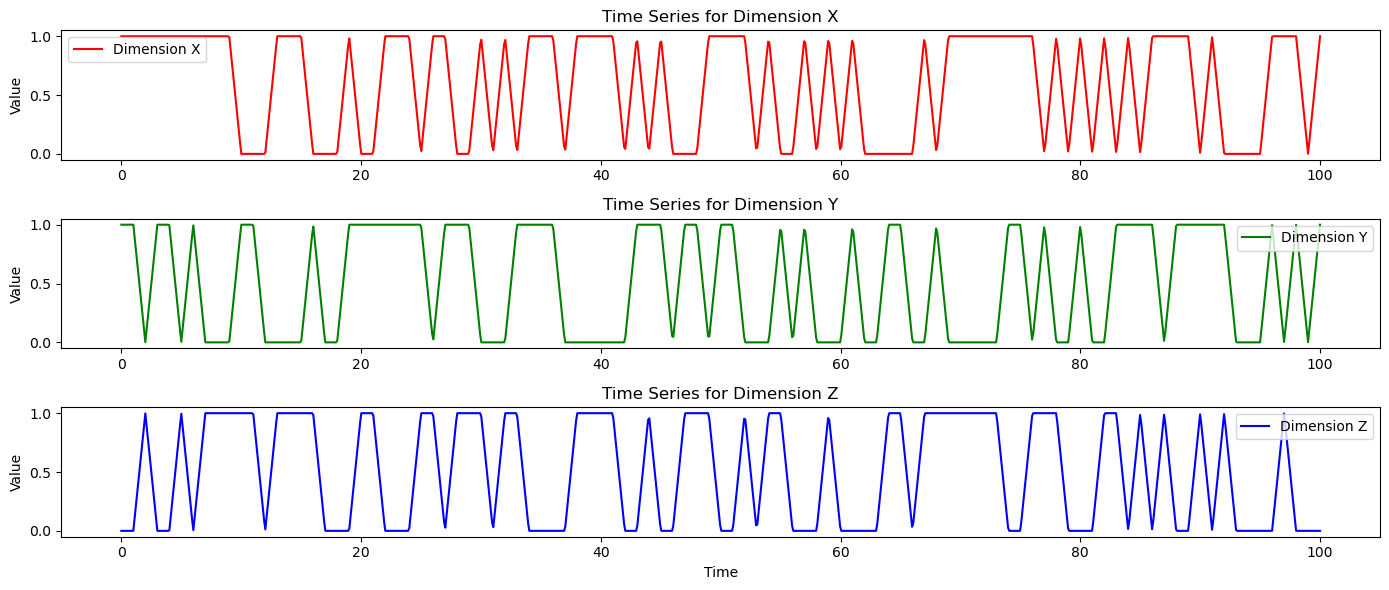

In [13]:
# MLS initialization
order = 10 #bit  # Define the size of the sequence
sequence3D = MaxLengthSequence3D(order, gain=1)

# Fetch values at a specific time t
t = 500.1
values_at_t = sequence3D.get_value_at_time(t)
print(f"Values at time {t}: {values_at_t}")


# Plot the time series for each dimension up to a specified length
sequence3D.plot_time_series(100)  # Plot the first 100 time steps for each dimension

In [40]:

##########################
# default parameters
##########################

# Define robot parameters (placeholders)
# theta = np.array([6.3922, 1.4338, 0.0706, 0.0653, 2.4552, 0.2868, 113.6538, 46.1168, 2.0993, 2.6, 2.5, 1.5])
theta = np.array([6.3922, 1.4338, 0.0706, 0.0653, 2.4552, 0.2868, 113.6538, 46.1168, 2.0993, 2.6, 2.5, 1.5])

# initial estimate of theta0
theta_hat0 = 0.5 * theta
pdim = len(theta_hat0)
ndim = 3 # state vector dim
nfilter = 4 # including Y1
q_d = np.array([np.pi/2, -np.pi/2, 0]) # desired position
init_y = np.array([0, 0, np.pi/2, 0, 0, 0])

f_const = {'lambda_phi' : 1.0, 
                'b2'    : 0.2, 
                'b3'    : 0.3, 
                'b4'    : 0.4, 
                'a2'    : 700.0, 
                'a3'    : 700.0, 
                'a4'    : 700.0, 
                'nfilter' : nfilter, 
                'ndim' : ndim, 
                'nrows' : nfilter * ndim, 
                'ncols' : pdim, 
                'theta' : theta,
                'TMAX' : 2, #  seconds
                'SWITCHFLAG' : False,   # if do regime switching
                'THREON' : False,   # if do thresholding for estimated value. Either 1. 'const' constant threshold, 2. 'Sigma_mod' Sigma modification
                'THRERT' : np.array([0.0, 2.0]),  # active when making thresholding on
                'DREMON' : True,        # if use drem adaptation f_theta
                'INTEGRALERROR' : False,        # if use drem adaptation f_theta
                'q_d' : q_d,    # desired position
                'noise_freq' : 5,  # hz
                'sigma_o' : 0.01,
                'init_y' : init_y,
                'theta_hat0' : theta_hat0,
                'EXT_F' : False, # if you input external force as MLS (M-系列)
                'EXT_F_GAIN' : [1, 1, 1], # if you input external force as MLS (M-系列)
                'ASYMDREM' : False, # update on DREM noise reduction asymptotically in RLS
                'CONTROLFLAG' : False, # define baseline tau
                'PHI0MODE' : False, # behavior of assimilation when phi close to 0
                }



###########################################
# Initial conditions: joint angles and velocities
tau = np.zeros(ndim)
Lambda_i = 5 * np.eye(ndim)  # lambda for integral error compensation
Lambda = 10 * np.eye(ndim) 
Kv =     10 * np.eye(ndim)
Psi =    10 * np.eye(pdim)
Gamma =  10 * np.eye(pdim)
Sigma_mod =  0.1 * np.eye(pdim)
alpha = 0.50001

control_gains = {
    'Lambda' : Lambda, 
    'Lambda_i' : Lambda_i, 
    'Kv' : Kv,
    'Psi' : Psi,
    'Gamma' : Gamma, 
    'alpha' : alpha,
    'Sigma_mod' : Sigma_mod,
    'Extern' : sequence3D.to_json()
}



Main routine

In [42]:
from Experiment import Experiment

exp_config1 = Experiment(exp_name='2000_DREMON_SIGMA001_THREON', 
                        DREMON=True, 
                        sig_o=0.000, 
                        THREON=False, 
                        TMAX=20.0, 
                        gain_multiple=20.0, 
                        INTEGRALERROR=False, 
                        Lambda_i=0.0, 
                        ASYMDREM=False, 
                        gain_Sigma_mod=0.0, 
                        ext_F=False, 
                        axx=70, 
                        SWITCHFLAG=False, 
                        EXT_F_GAIN=[0, 0, 0], 
                        CONTROLFLAG=False,
                        b2=0.2, 
                        b3=0.3,
                        b4=0.4,  )
 
exp_config2 = Experiment(exp_name='2001_DREMON_SIGMA001_THREON', 
                        DREMON=True, 
                        sig_o=0.000, 
                        THREON=False, 
                        TMAX=20.0, 
                        gain_multiple=20.0, 
                        INTEGRALERROR=False, 
                        Lambda_i=0.0, 
                        ASYMDREM=False, 
                        gain_Sigma_mod=0.0, 
                        ext_F=False, 
                        axx=70, 
                        SWITCHFLAG=False, 
                        EXT_F_GAIN=[0, 0, 0], 
                        CONTROLFLAG=False,
                        b2=0.2, 
                        b3=0.3,
                        b4=0.4,
                        phi0mode=True,
                                )
 


# define experiment name
exp_list = [
           #('136_DREMON_SIGMA001_THREOFF', True, 0.001,  False,       100.0, 10, True, 0.01, False, 0.0) , # condition 19  extension
            #('236_DREMON_SIGMA001_THREOFF', True, 0.001,  False,       100.0, 10, True, 0.01, 'RLS', 0.0) , # condition 19  extension
            #('336_DREMON_SIGMA001_THREOFF', True, 0.001,  'Sigma_mod', 100.0, 10, True, 0.01, False, 1.0) , # condition 19  extension
            #('436_DREMON_SIGMA001_THREOFF', True, 0.001,  'Sigma_mod', 100.0, 10, True, 0.01, 'RLS', 1.0) , # condition 19  extension
            #('536_DREMON_SIGMA001_THREOFF', True, 0.001,  'Sigma_mod', 100.0, 10, True, 0.01, False, 0.1) , # condition 19  extension
            #('636_DREMON_SIGMA001_THREOFF', True, 0.001,  'Sigma_mod', 100.0, 10, True, 0.01, 'RLS', 0.1) , # condition 19  extension
            #('736_DREMON_SIGMA001_THREOFF', True, 0.001,  'Sigma_mod', 100.0, 10, True, 0.01, 'RLS_P', 0.1) , # condition 19  extension
            #('836_DREMON_SIGMA001_THREOFF', True, 0.001,  False,       100.0, 10, True, 0.01, 'RLS_P', 0.0) , # condition 19  extension
            #('836_DREMON_SIGMA001_THREOFF', True, 0.001,  False,       100.0, 10, False, 0.01, 'RLS_P', 0.0) , # condition 19  extension
              # ('37_DREMOFF_SIGMA001_THREOFF', False, 0.001,  False, 20.0, 10, True, 0.01) , # condition 19  extension
            # ('38_DREMON_SIGMA001_THREON', True, 0.001,  True, 20.0, 10, True, 0.01) , # condition 19  extension
            # ('39_DREMOFF_SIGMA001_THREON', False, 0.001,  True, 20.0, 10, True, 0.01) , # condition 19  extension
            #('28_DREMON_SIGMA001_THREON', True, 0.001,  True, 100.0, 10, True, 0.01,  False, 0.0, False, 700, True, [0, 0, 0], False) , # condition 19  extension
            #('48_DREMON_SIGMA001_THREON', True, 0.001,  True, 100.0, 10, True, 0.1) , # condition 19  extension
            # ('48_DREMON_SIGMA001_THREON', True, 0.001,  'Sigma_mod', 20.0, 10, True, 0.01) , # condition 19  extension
            # ('58_DREMON_SIGMA001_THREON', True,        0.001,  'Sigma_mod', 20.0, 10, True, 0.01, False) , # condition 19  extension
            #('68_DREMON_SIGMA001_THREON', 'DREM_ONLY', 0.001,  'Sigma_mod', 20.0, 10, True, 0.01, False) , # condition 19  extension
            # ('78_DREMON_SIGMA001_THREON', 'DREM_ONLY', 0.001,  'Sigma_mod', 20.0, 10, True, 0.01, 'RLS') , # condition 19  extension
            #('1000_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, True, 30, False, 1) , # condition 19  extension
            #('1001_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, False, 1) , # condition 19  extension
            #('1002_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.000,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, False, 1) , # condition 19  extension
            #('1006_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, True, 30, True, [2, 2, 2]) , # condition 19  extension
            #('1007_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, True, [2, 2, 2]) , # condition 19  extension
            #('1008_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.000,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, True, [2, 2, 2]) , # condition 19  extension
            #('1003_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, True, 30, True, [5, 5, 1]) , # condition 19  extension
            #('1004_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, True, [5, 5, 1]) , # condition 19  extension
            #('1005_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.000,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, True, [5, 5, 1]) , # condition 19  extension
            #('1009_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, True, 30, True, [10, 5, 1]) , # condition 19  extension
            #('1010_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.001,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, True, [10, 5, 1]) , # condition 19  extension
            #('1011_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.000,  False,       100.0, 1.0, False,  0.01, False, 0.0, False, 30, True, [10, 5, 1]) , # condition 19  extension
            #('1012_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.01,  False,       100.0, 10.0, False,  0.01, False, 0.0, True, 30, True, [0, 0, 0]) , # condition 19  extension
            #('1013_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.01,  False,       100.0, 10.0, False,  0.01, False, 0.0, False, 30, True, [0, 0, 0]) , # condition 19  extension
            #('1014_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.000,  False,       100.0, 10.0, False,  0.01, False, 0.0, False, 30, True, [0, 0, 0]) , # condition 19  extension
            #('1015_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.01,  False,       100.0, 10.0, False,  0.01, False, 0.0, False, 30, True, [0, 0, 0], 'YaZERO') , # condition 19  extension
            #('1016_DREMON_SIGMA001_THREOFF', 'YaZERO', 0.01,  False,       100.0, 10.0, False,  0.01, False, 0.0, False, 30, True, [0, 0, 0], 'NOISEFEED') , # condition 19  extension
            #('2029_DREMON_SIGMA001_THREON', True, 0.001,  False, 20.0, 10, False, 0.00,  False, 0.0, False, 70, False, [0, 0, 0], False) , # condition 19  extension
            #('2000_DREMON_SIGMA001_THREON', True, 0.000,  False, 5.0, 10, False, 0.00,  False, 0.0, False, 700, False, [0, 0, 0], False) , # condition 19  extension
 
             ]




for exp_name, DREMON, sig_o, THREON, TMAX, gain_multiple, INTEGRALERROR, Lambda_i, ASYMDREM, \
gain_Sigma_mod, ext_F, axx, SWITCHFLAG, EXT_F_GAIN, CONTROLFLAG, b2, b3, b4, phi0mode  \
      in [exp_config.to_dict().values() for exp_config in [exp_config2]]:
    
    
    ###########################################
    f_const['TMAX'] = TMAX #  seconds
    # modify default params for experiments
    f_const['DREMON'] = DREMON
    f_const['sigma_o'] = sig_o
    f_const['THREON'] = THREON 
    f_const['INTEGRALERROR'] = INTEGRALERROR
    f_const['EXT_F'] = ext_F
    control_gains['Lambda'] = gain_multiple * np.eye(ndim) 
    control_gains['Kv'] =     gain_multiple * np.eye(ndim)
    control_gains['Psi'] =    gain_multiple * np.eye(pdim)
    control_gains['Gamma'] =  gain_multiple * np.eye(pdim)
    control_gains['Lambda_i'] = Lambda_i * np.eye(ndim) 
    control_gains['Sigma_mod'] =  gain_Sigma_mod * np.eye(pdim)
    f_const['ASYMDREM'] = ASYMDREM
    f_const['a2'] = axx
    f_const['a3'] = axx
    f_const['a4'] = axx
    f_const['b2'] = b2
    f_const['b3'] = b3
    f_const['b4'] = b4
    f_const['SWITCHFLAG'] = SWITCHFLAG
    f_const['Ext_F_GAIN'] = EXT_F_GAIN 
    f_const['CONTROLFLAG'] = CONTROLFLAG 
    f_const['PHI0MODE'] = phi0mode
    
    # change external input gain if set
    if f_const['EXT_F'] == True:
        sequence3D.change_gain(f_const['Ext_F_GAIN'])

    ###########################################
    
    # define filtered regressors
    Yphi =   np.zeros((f_const['nfilter'] * f_const['ndim'], f_const['ncols']))
    tauphi = np.zeros((f_const['nrows']))
    ei0 = np.zeros((f_const['ndim']))
    phi2sum0 = [0] # integration of phi2
    P0 = np.zeros((f_const['nfilter'] * f_const['ndim'], f_const['ncols'])) # integration of Ya.T@Ya 

     # Time points to evaluate the solution
    t = np.linspace(0, f_const['TMAX'], int(f_const['TMAX']*f_const['noise_freq'] + 1))
     # Time span for the simulation
    t_span = [0.0, f_const['TMAX']]  
    
    # noise
    np.random.seed(seed=32)
    noise_info =  stack_noise(f_const['ndim'], n_samples=int(f_const['TMAX']*f_const['noise_freq'] + 1), tbegin=0, tend=f_const['TMAX'], dbgfig=0, sigma_o=f_const['sigma_o'])
    noise_interp_dict = wrap_interp_func(t, noise_info) # wrapper for interpolate computation
    
    # initial condition
    ytheta0 = np.concatenate([f_const['init_y'], f_const['theta_hat0'], Yphi.flatten(), tauphi.flatten(), ei0.flatten(), phi2sum0, P0.flatten()])  # (q, q_dot, theta_hat, Yf, tauf)
    
   
   
    # prepare noise interp function
 
    # Initialize the progress bar
    initial_time, final_time = t_span  # Assuming t_span is defined somewhere as [initial_time, final_time]
    total_time = final_time - initial_time
    pbar = tqdm(total=total_time)
    # Create a tqdm progress bar
    
    # Wrapper function to update progress bar based on current time t
    def wrapper(t, y, *args):
        current_progress = t - initial_time
        # Update the progress bar to reflect current progress
        # Note: set_postfix can be used to display additional information
        pbar.n = current_progress
        pbar.last_print_n = current_progress
        pbar.refresh()
        return robot_dynamics_w_control_adaptation(t, y, *args)


    # delete prior Solve 
    # try:
    #     del sol, y  # Attempt to delete 'my_variable'
    # except NameError:
    #     print("sol, y is not defined or already deleted.")
 
    # Evaluate the solution
    #sol = solve_ivp(robot_dynamics_w_control_adaptation, t_span, ytheta0, args=( control_gains, f_const, noise_info, ), dense_output=True, rtol=1e-3, atol=1e-6, events=callback)
    #sol = solve_ivp(wrapper, t_span, ytheta0, args=( control_gains, f_const, noise_interp_dict, ), dense_output=False, rtol=1, atol=1, max_step=0.0001, t_eval=t)
    sol = solve_ivp(wrapper, t_span, ytheta0, args=( control_gains, f_const, noise_interp_dict, sequence3D), dense_output=False, rtol=1e-2, atol=1e-2, t_eval=t)
    #sol = solve_ivp(wrapper, t_span, ytheta0, args=( control_gains, f_const, noise_interp_dict, sequence3D), dense_output=False, rtol=1e-0, atol=1e-0, t_eval=t, method="RK45", max_step=0.0001)
    y = sol.y
    #sol = solve_ivp(wrapper, t_span, ytheta0, args=( control_gains, f_const, noise_interp_dict, ), dense_output=True, rtol=1e-3, atol=1e-6, t_eval=t)
    #y = sol.sol(t)
    
    
    # Close the progress bar after the integration is complete
    pbar.close()


    ####################################################    
    # post process 
    ####################################################    

    # show analysis resutls
    save_dir = 'img/'
    savepath = os.path.join(save_dir, exp_name)
    analysis_result(t,y,theta_hat0, f_const, save=True, savepath=savepath, figshow=0, )
    
    # merge dictionaries
    parameters = f_const | control_gains | noise_info
    save_params(parameters,   savepath=savepath)
    save_params(f_const,      savepath=savepath, filename='f_const.json')
    save_params(control_gains,savepath=savepath, filename='control_gains.json')
    save_params(noise_info,   savepath=savepath, filename='noise_info.json')

    # save result
    save_as_pickle(sol, savepath + '/solution.pickle')



  0%|          | 0/20.0 [00:00<?, ?it/s]

In [59]:
tauf = sol.y[6+len(theta)+f_const['nrows']*f_const['ncols'] : 6+len(theta)+f_const['nrows']*f_const['ncols'] + f_const['nrows']][:,-1]
Yf = sol.y[6+len(theta)                                   : 6+len(theta)+f_const['nrows']*f_const['ncols']][:,-1].reshape([f_const['nrows'], f_const['ncols']])

In [61]:
np.linalg.inv(Yf)@tauf

array([6.63883783e+00, 1.15720422e+00, 9.64662083e-02, 5.25048278e-02,
       2.12939930e+00, 2.75621533e-01, 1.11115137e+02, 4.55118108e+01,
       2.06733107e+00, 4.89533906e+00, 3.63703922e+00, 1.52441622e+00])

In [62]:
theta

array([6.392200e+00, 1.433800e+00, 7.060000e-02, 6.530000e-02,
       2.455200e+00, 2.868000e-01, 1.136538e+02, 4.611680e+01,
       2.099300e+00, 2.600000e+00, 2.500000e+00, 1.500000e+00])

In [56]:
 sol.y[6+len(theta)                                   : 6+len(theta)+f_const['nrows']*f_const['ncols']].shape

(144, 101)

In [45]:
DREM_routine.elapsed_dict

NameError: name 'DREM_routine' is not defined

In [75]:
np.diag(sol.y[-144:, -1].reshape(12,12))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [161]:
import pickle
file_exp16 = '/Users/hiroki/Dropbox/PJ ModelDetection/DREM/DREM_implementation/img/936_DREMON_SIGMA001_THREOFF/solution.pickle'
with open(file_exp16, 'rb') as f:
    foo = pickle.load(f)

In [197]:
foo.y[:,-1][-144:].reshape(12,12)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:

with open(file_exp16, 'wb') as f:
    pickle.dump(foo, f)

In [36]:
foo.sol = None

In [75]:

# Function to display memory usage of variables
def display_memory_usage():
    print("Variable Name\tMemory Usage")
    for variable_name in globals().copy():
        # Filter out system and module variables
        if not variable_name.startswith("_") and variable_name not in sys.modules:
            print(f"{variable_name}\t{sys.getsizeof(globals()[variable_name])} bytes")

# Call the function to display memory usage
display_memory_usage()

Variable Name	Memory Usage
In	664 bytes
Out	632 bytes
get_ipython	64 bytes
exit	56 bytes
quit	56 bytes
open	152 bytes
np	72 bytes
solve_ivp	152 bytes
plt	72 bytes
stack_noise	152 bytes
robot_dynamics_w_control_adaptation	152 bytes
analysis_result	152 bytes
save_params	152 bytes
save_as_pickle	152 bytes
wrap_interp_func	152 bytes
parse_noise_interp_dict	152 bytes
MaxLengthSequence3D	1688 bytes
order	28 bytes
sequence3D	56 bytes
t	112 bytes
exp_list	56 bytes
exp_name	76 bytes
DREMON	28 bytes
sig_o	24 bytes
THREON	28 bytes
TMAX	24 bytes
gain_multiple	28 bytes
INTEGRALERROR	28 bytes
Lambda_i	24 bytes
ASYMDREM	28 bytes
gain_Sigma_mod	24 bytes
ext_F	28 bytes
axx	28 bytes
SWITCHFLAG	28 bytes
EXT_F_GAIN	88 bytes
values_at_t	64 bytes
theta	208 bytes
theta_hat0	208 bytes
pdim	28 bytes
ndim	28 bytes
nfilter	28 bytes
q_d	136 bytes
init_y	160 bytes
f_const	832 bytes
tau	136 bytes
Lambda	200 bytes
Kv	200 bytes
Psi	1280 bytes
Gamma	1280 bytes
Sigma_mod	1280 bytes
alpha	24 bytes
control_gains	272 byte

In [18]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.000e-01 ...  9.980e+01  1.000e+02]
        y: [[ 0.000e+00  1.328e+00 ...  1.571e+00  1.570e+00]
            [ 0.000e+00 -1.373e+00 ... -1.570e+00 -1.570e+00]
            ...
            [ 0.000e+00  2.026e+03 ...  2.107e+00  5.226e-01]
            [ 0.000e+00 -2.647e+02 ...  2.318e-01 -1.471e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1007030
     njev: 0
      nlu: 0

In [ ]:
f_const['noise_freq']

10

In [ ]:
# def theta_dot_thre(theta_hat, theta, ratio, theta_hat_dot):
#     # ratio indicates parameter estimation errror allowance
#     # currently only define for theta>0 case
# 
#     def are_all_positive(numbers):
#         return all(n > 0 for n in numbers)
#     
#     # Example usage
# 
# 
#     if are_all_positive(theta):
#         theta_hat_dot [( theta * ratio[0] > theta_hat) & (theta_hat_dot<0) ] = 0
#         theta_hat_dot [( theta * ratio[1] < theta_hat) & (theta_hat_dot>0) ] = 0
#         return theta_hat_dot
# 
#     else:
#         raise ValueError("Not all elements are positive.")
# 
# 
# 
# numbers = np.array([1,2,3,4,5])
# estimate = np.random.rand(5) - 1/2
# theta_hat_dot = np.random.rand(5) - 1/2
# theta_dot_thre(estimate, numbers, np.array([0.2, 2]), theta_hat_dot)

In [15]:
    y = sol.y
    
    # Close the progress bar after the integration is complete
    pbar.close()


    ####################################################    
    # post process 
    ####################################################    

    # show analysis resutls
    save_dir = 'img/'
    savepath = os.path.join(save_dir, exp_name)
    analysis_result(t,y,theta_hat0, f_const, save=True, savepath=savepath, figshow=0, )
    
    # merge dictionaries
    parameters = f_const | control_gains | noise_info
    save_params(parameters,   savepath=savepath)
    save_params(f_const,      savepath=savepath, filename='f_const.json')
    save_params(control_gains,savepath=savepath, filename='control_gains.json')
    save_params(noise_info,   savepath=savepath, filename='noise_info.json')

    # save result
    save_as_pickle(sol, savepath + '/solution.pickle')


Directory 'img/18_DREMON_SIGMA001_THREOFF' was created.
Parameters have been saved to img/18_DREMON_SIGMA001_THREOFF/parameters.json.
Parameters have been saved to img/18_DREMON_SIGMA001_THREOFF/f_const.json.
Parameters have been saved to img/18_DREMON_SIGMA001_THREOFF/control_gains.json.
Parameters have been saved to img/18_DREMON_SIGMA001_THREOFF/noise_info.json.
Variable successfully saved to img/18_DREMON_SIGMA001_THREOFF/solution.pickle


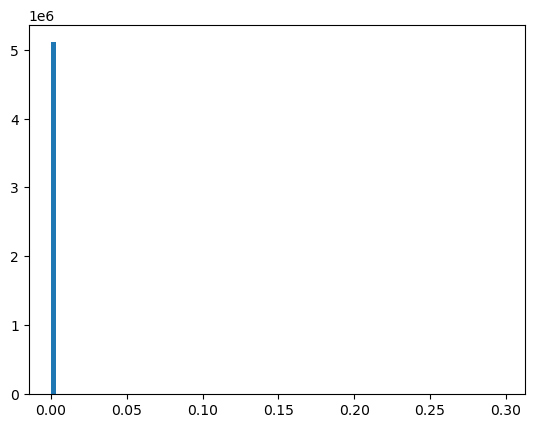

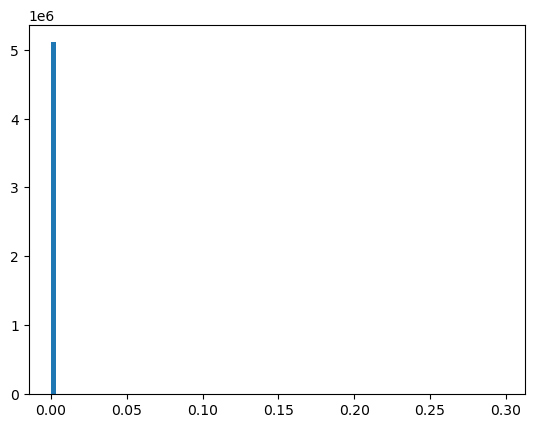

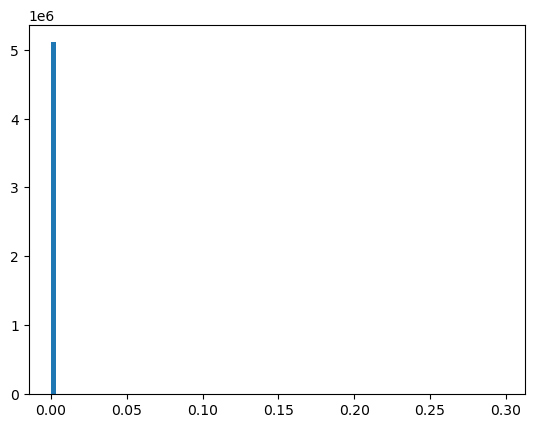

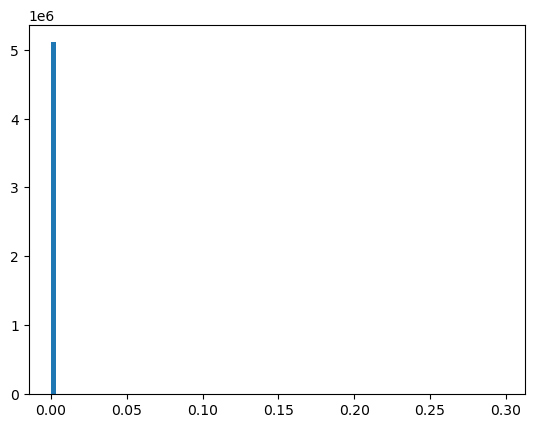

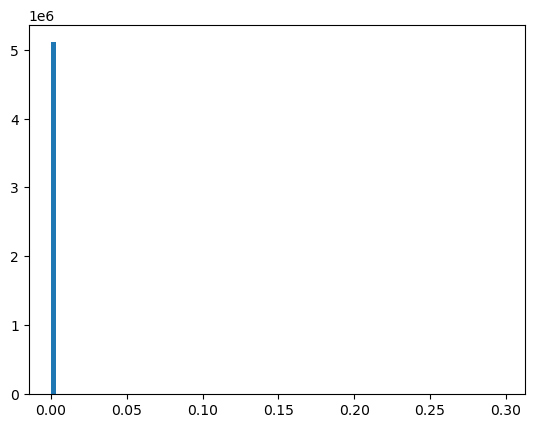

In [76]:
import DREM_routine
plt.hist(DREM_routine.elapsed_dict['et1'], bins=100)
plt.show()
plt.hist(DREM_routine.elapsed_dict['et2'], bins=100)
plt.show()
plt.hist(DREM_routine.elapsed_dict['et3'], bins=100)
plt.show()
plt.hist(DREM_routine.elapsed_dict['et4'], bins=100)
plt.show()
plt.hist(DREM_routine.elapsed_dict['et5'], bins=100)
plt.show()